In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
import pickle
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [4]:
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Walking", "Standing"]

In [5]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("C:/Users/GACHON/Desktop/AiStudy/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [6]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [8]:
df = df[~df['activity'].str.contains('Jogging|Sitting|Upstairs|Downstairs')]

In [9]:
print(df['activity'].value_counts())

activity
Walking     424397
Standing     48395
Name: count, dtype: int64


Text(0.5, 1.0, 'Activity Type')

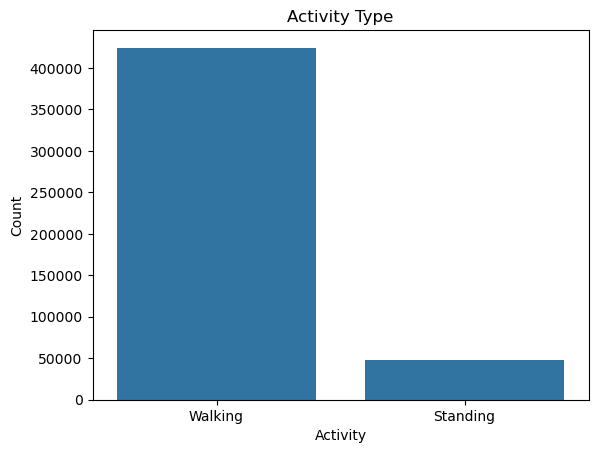

In [10]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data = df, x="activity")
plt.xlabel('Activity')
plt.ylabel("Count")
plt.title('Activity Type')

In [11]:
mapping = {'Walking': 0, 'Standing': 1}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
597,33,Walking,49394992294000,0.844462,8.008764,2.792171,0
598,33,Walking,49395102310000,1.116869,8.621680,3.786457,0
599,33,Walking,49395202316000,-0.503953,16.657684,1.307553,0
600,33,Walking,49395302292000,4.794363,10.760075,-1.184970,0
601,33,Walking,49395412338000,-0.040861,9.234595,-0.694638,0
...,...,...,...,...,...,...,...
1095664,19,Standing,131477821443000,-4.990000,8.390000,-0.380000,1
1095665,19,Standing,131477861513000,-5.130000,8.240000,-0.420000,1
1095666,19,Standing,131477941499000,-4.560000,8.500000,-0.890000,1
1095667,19,Standing,131477981508000,-4.480000,8.540000,-1.080000,1


In [12]:
df.shape

(472792, 7)

C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\GACHON\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


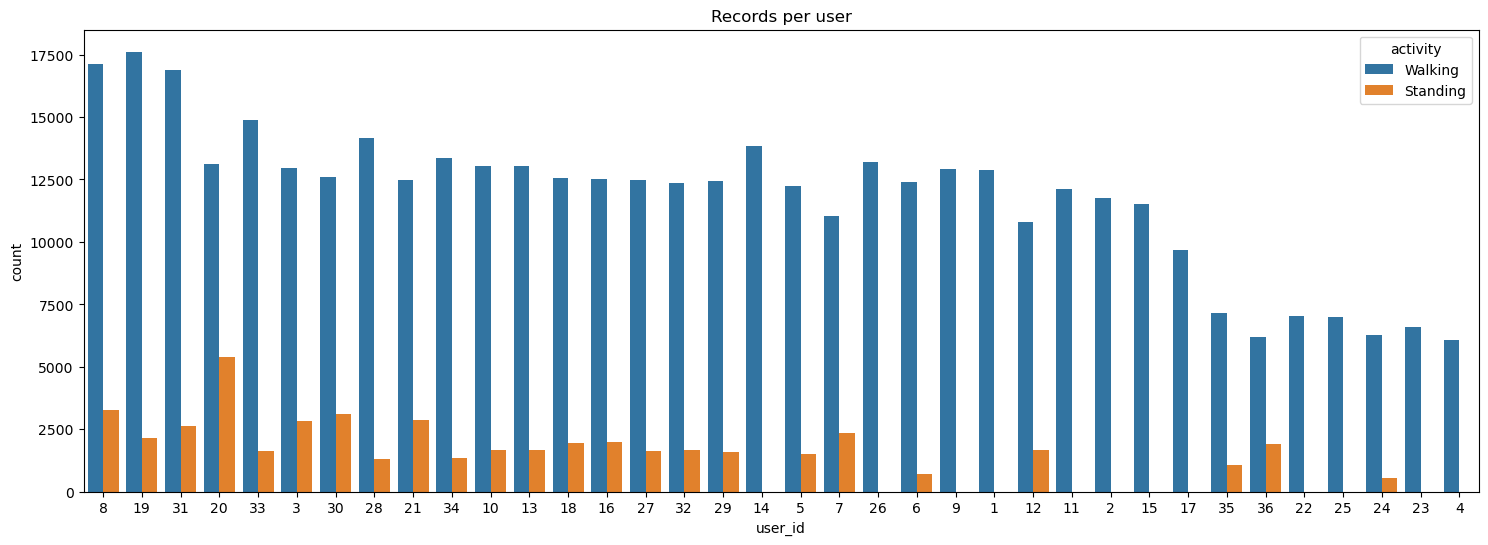

In [13]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

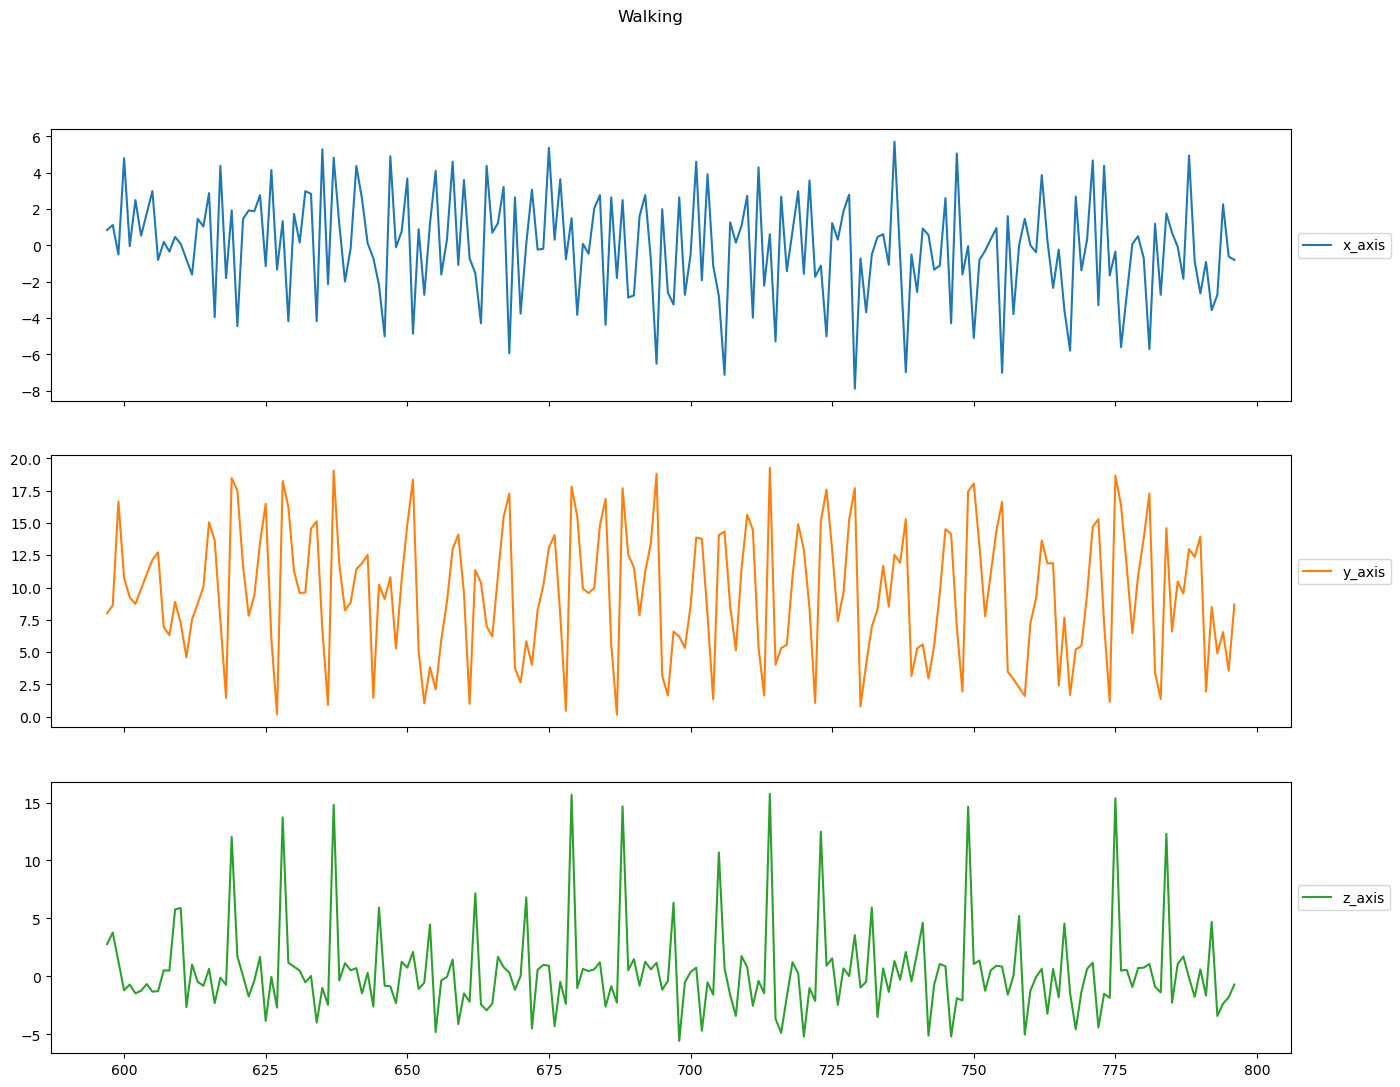

In [14]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Walking", df)

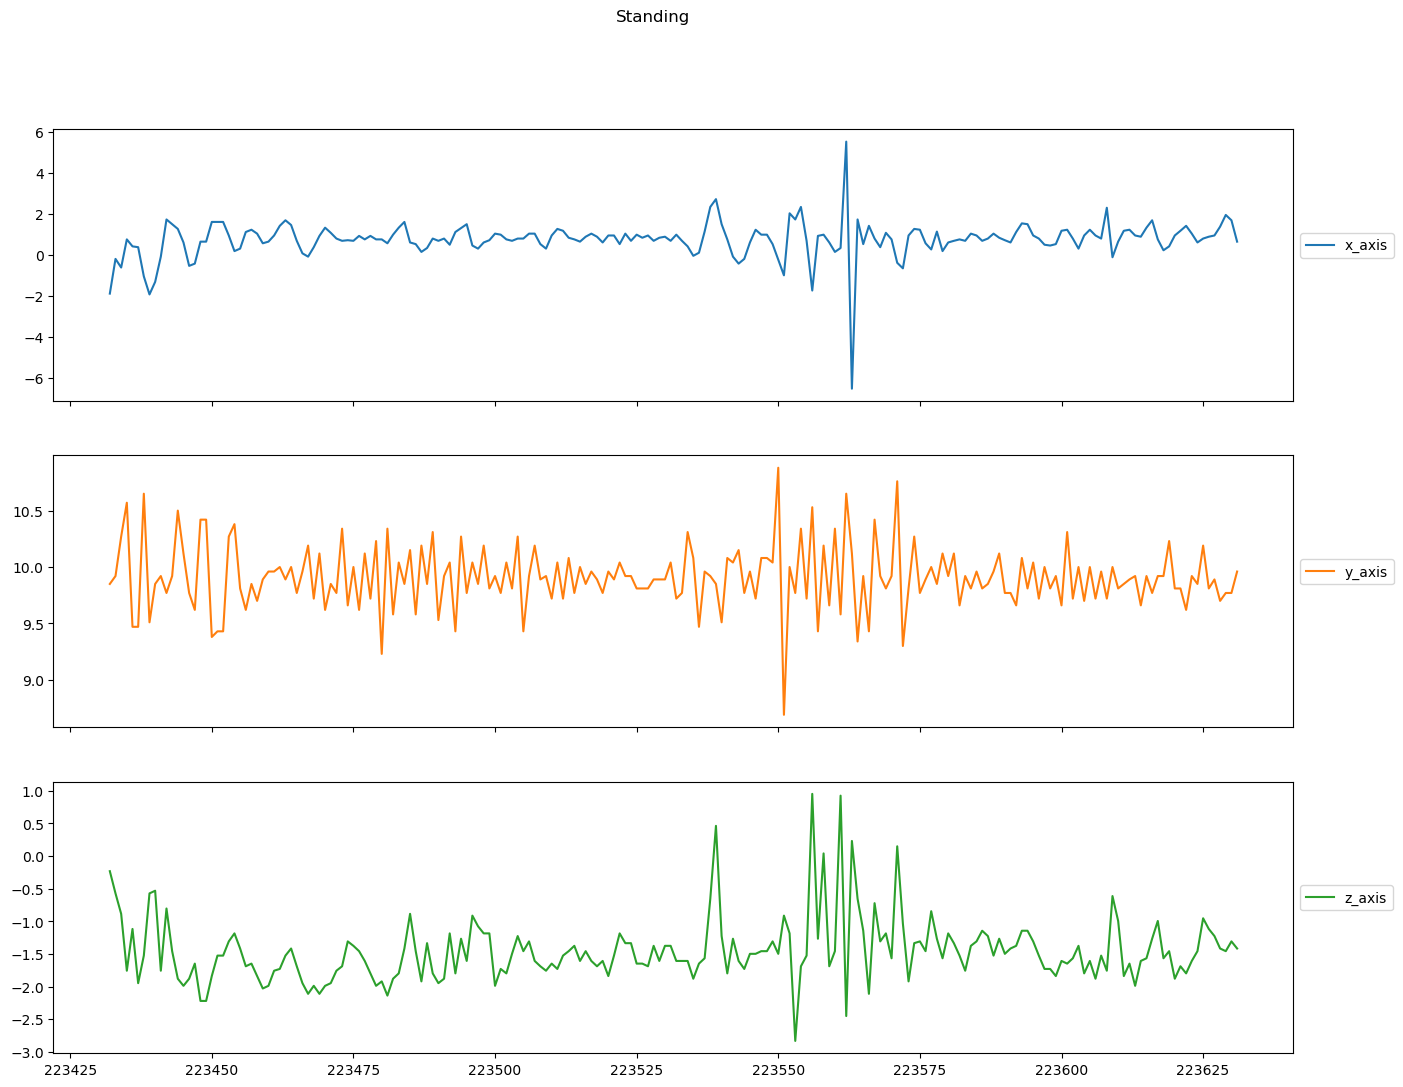

In [15]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [16]:
Walking = df[df.ActivityEncoded == 0]
Standing = df[df.ActivityEncoded == 1]
Walking.shape

(424397, 7)

In [17]:
Standing.shape

(48395, 7)

In [18]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['activity'], axis=1)

# 센서 데이터만 선택하여 새로운 데이터프레임 생성
sensor_data = data[['x_axis', 'y_axis', 'z_axis']]

# 특성 스케일링 수행
scaler = StandardScaler()
scaled_sensor_data = scaler.fit_transform(sensor_data)

# 스케일링된 데이터를 기존 데이터프레임에 다시 할당
df[['x_axis', 'y_axis', 'z_axis']] = scaled_sensor_data

In [19]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.ActivityEncoded == 0]
X_train = X_train.drop(['ActivityEncoded'], axis=1)

y_test = X_test['ActivityEncoded']
X_test = X_test.drop(['ActivityEncoded'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(339571, 5)

In [20]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

# 데이터셋 생성
X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS, STEP)

# X 데이터 특성 스케일링
scaler = StandardScaler()
scaled_X_data = scaler.fit_transform(X_data.reshape(X_data.shape[0], -1))

In [21]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X_data, y_data, test_size=0.2, random_state=RANDOM_SEED)

# 훈련 데이터에서 정상 데이터만 선택
X_train = X_train[y_train.flatten() == 0]

# 테스트 데이터의 레이블 열 제거
y_test = np.squeeze(y_test)

print(X_train.shape)

(8473, 600)


In [22]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                              save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 1s 3ms/step - loss: 1.0301 - accuracy: 0.0014 - val_loss: 0.9112 - val_accuracy: 0.0013
Epoch 2/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9820 - accuracy: 9.4418e-04 - val_loss: 0.8896 - val_accuracy: 0.0013
Epoch 3/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9692 - accuracy: 0.0015 - val_loss: 0.8811 - val_accuracy: 0.0017
Epoch 4/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9600 - accuracy: 0.0011 - val_loss: 0.8744 - val_accuracy: 0.0025
Epoch 5/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9532 - accuracy: 0.0026 - val_loss: 0.8696 - val_accuracy: 0.0030
Epoch 6/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9483 - accuracy: 0.0031 - val_loss: 0.8648 - val_accuracy: 0.0017
Epoch 7/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9428 - accuracy: 0.0042 - val_loss: 0.8600 - val_accuracy: 0.0047
Ep

In [24]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
#checkpointer = ModelCheckpoint(filepath="model.h5",
#                               verbose=0,
#                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
265/265 [==============================] - 1s 4ms/step - loss: 0.9289 - accuracy: 0.0051 - val_loss: 0.8496 - val_accuracy: 0.0068
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 0.9273 - accuracy: 0.0067 - val_loss: 0.8484 - val_accuracy: 0.0051
Epoch 3/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9260 - accuracy: 0.0064 - val_loss: 0.8471 - val_accuracy: 0.0055
Epoch 4/10
265/265 [==============================] - 1s 4ms/step - loss: 0.9247 - accuracy: 0.0060 - val_loss: 0.8463 - val_accuracy: 0.0076
Epoch 5/10
265/265 [==============================] - 1s 4ms/step - loss: 0.9236 - accuracy: 0.0058 - val_loss: 0.8449 - val_accuracy: 0.0042
Epoch 6/10
265/265 [==============================] - 1s 4ms/step - loss: 0.9224 - accuracy: 0.0070 - val_loss: 0.8444 - val_accuracy: 0.0055
Epoch 7/10
265/265 [==============================] - 1s 3ms/step - loss: 0.9214 - accuracy: 0.0063 - val_loss: 0.8428 - val_accuracy: 0.0051
Epoch 

In [25]:
autoencoder = load_model('model.h5')

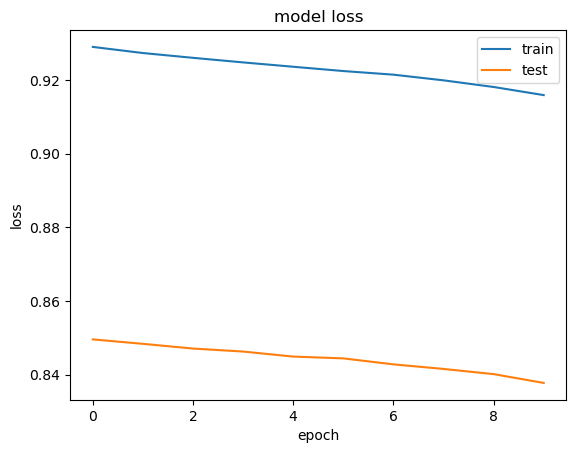

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [27]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

74/74 [==============================] - 0s 836us/step


,reconstruction_error,true_class
count,2363.000000,2363.000000
mean,0.836719,0.095641
std,0.585742,0.294161
min,0.005035,0.000000
25%,0.522491,0.000000
50%,0.786546,0.000000
75%,0.979336,0.000000
max,4.062408,1.000000


## Walkig 데이터들의 재구성 오류 분포

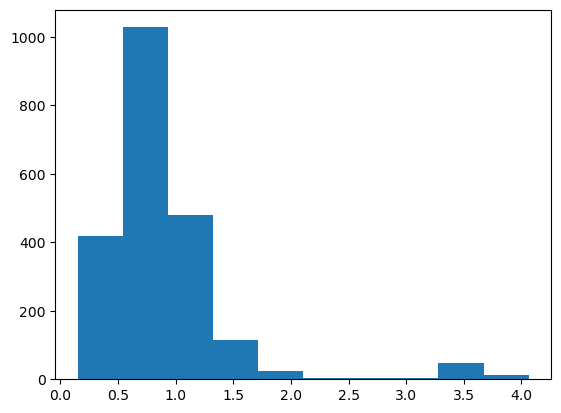

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Standing 데이터들의 재구성 오류 분포

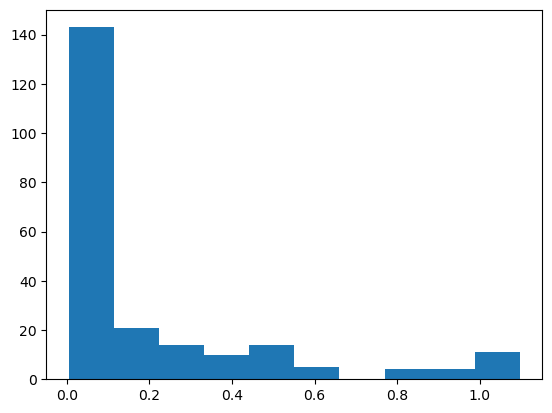

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

## ROC 곡선을 통한 평가

In [30]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

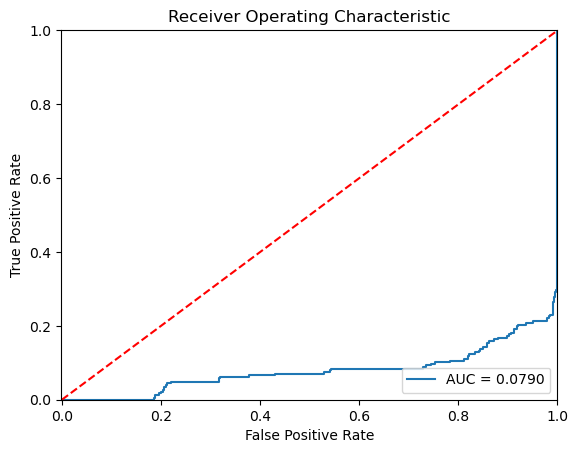

In [31]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [32]:
#ROC 곡선은 각 기준치(threshold)가 달라질 때마다 '틀린 것을 맞다고 할 확률'(false positive rate)에 따른 '맞는 것을 맞다고 한 확률'(true positive rate)을 그래프로 그린 것
#기본적으로, 파란색 곡선이 왼쪽 위 모퉁이에 가까워질수록 좋음

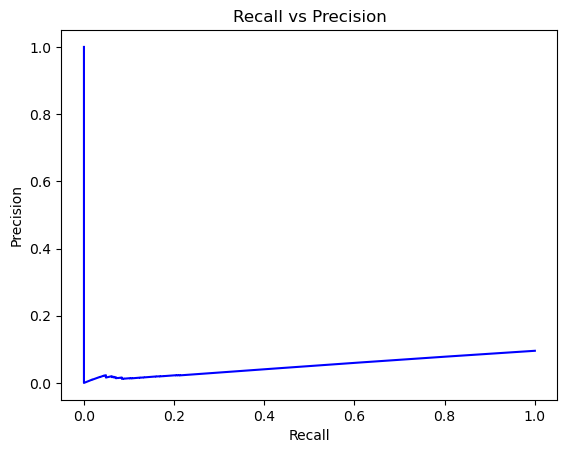

In [33]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

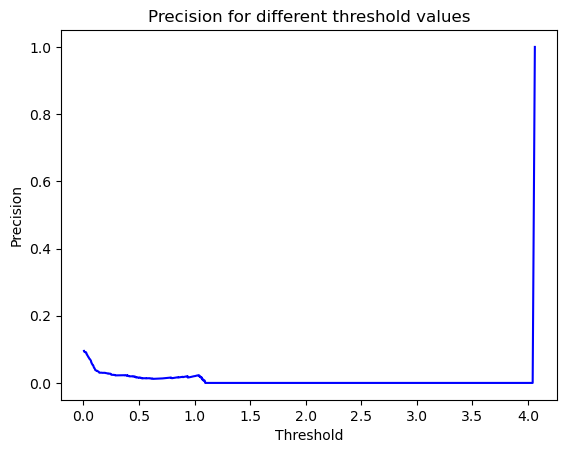

In [34]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

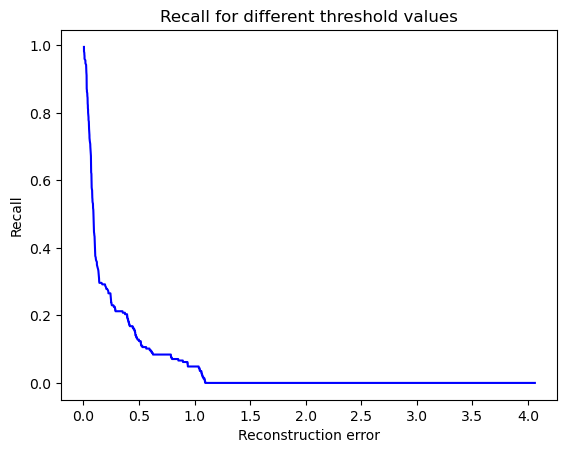

In [35]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [39]:
threshold = 0.2

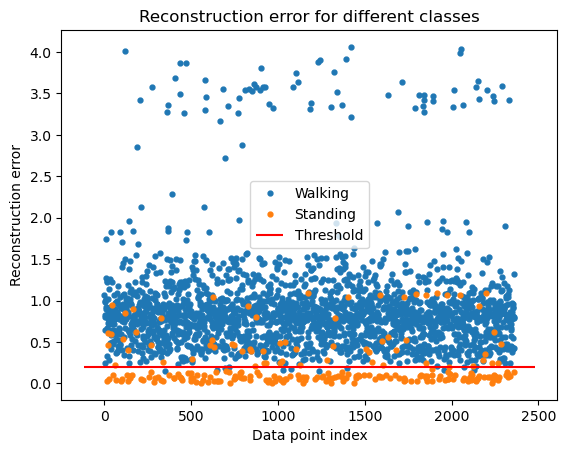

In [40]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Standing" if name == 1 else "Walking")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

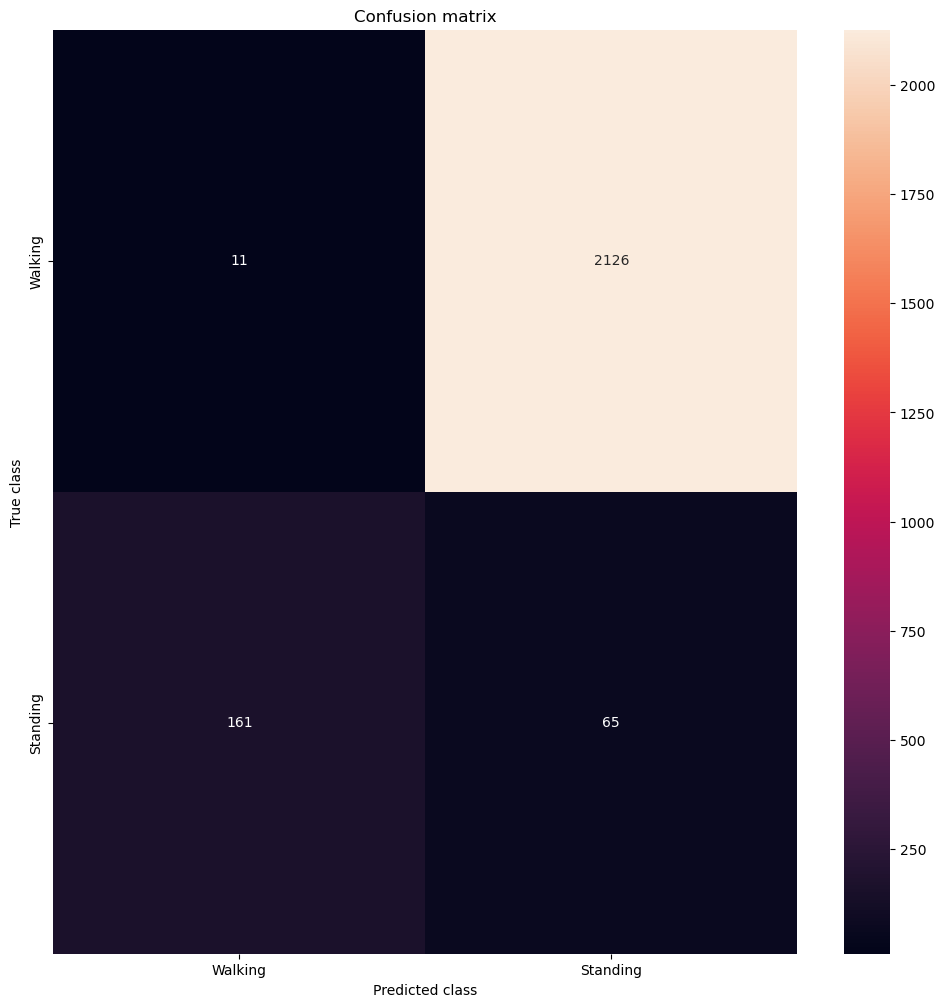

In [41]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()